## Bias correction

This code block aims to apply bias correction to the dataset with rain gauge data to remove systematic bias in the dataset. Systematic bias may be induced due to inherent uncertainties in remote sensing equipment or flaw in the algorithm used to convert sensor data to precipitation.
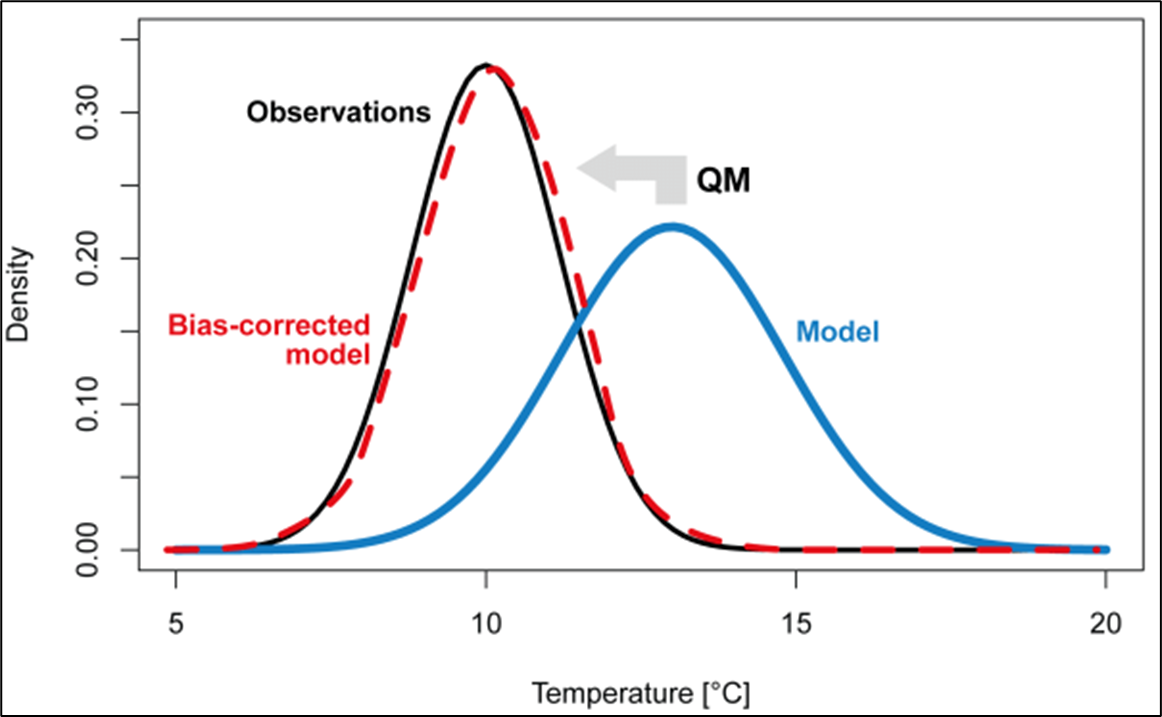

We will use the CMORPH dataset here due to its high correlation and data performance

In [ ]:
!pip install matplotlib
!pip install ibicus
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn

## Read this very important to understand how ibicus debiaser works

Ibicus debiaser module has many different methods such as Delta Change and what not. For the purpose of this exercise we will use the quantile mapping bias correction method. The Ibicus quantile mapping method works with 3 arguments:

1) Obs_historical - Historical real data
2) CM_historical - Historical data from model
3) CM_future - Future data from model

Ibicus QM takes Obs_historical to correct CM_historical and create a transfer function which is then applied to CM_future to get "Obs_future" data

The problem is that Ibicus package was designed to bias correct gridded map data and /**takes in 3 dimensional inputs**/. However, this is not suited for our application as we are using point data over an observed time period which at best gives us a 1 dimensional array in the time dimension. To overcome this we can extract "point" data from grids by getting the sqy=uare that contains the point of interest. Then we use reshaping or padding to transform the array to a 3 dimensional array to fit into Ibicus. While it might not be entirely accurate, this is a good enough work around.

The alternative is kriging but it kills your computer so nah.

ALSO make sure you correct your sampling time period to match the temporal resolutions

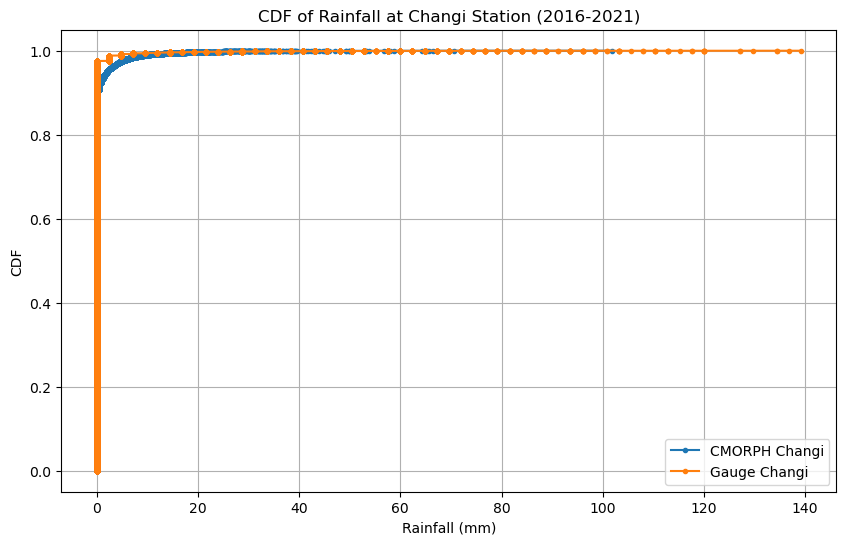

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import warnings
from ibicus.debias import QuantileMapping, DeltaChange, ScaledDistributionMapping, CDFt, ECDFM, QuantileDeltaMapping, ISIMIP
from scipy.stats import kstest

warnings.filterwarnings("ignore")

# Load datasets
CMORPH = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\CMORPH_10yrs.csv")
Gauge = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\Data_gov_Station_10_years.csv")

# Convert the 'Date' column to datetime for CMORPH
CMORPH["Datetime"] = pd.to_datetime(CMORPH["Datetime"])

# Convert the 'Datetime' column to datetime for Gauge
Gauge["Datetime"] = pd.to_datetime(Gauge["Datetime"], format='%d/%m/%Y %H:%M')

# Define the date range
start_date = '2016-03-12'
end_date = '2021-12-31'

# Filter the data for the date range
CMORPH = CMORPH.loc[(CMORPH['Datetime'] > start_date) & (CMORPH['Datetime'] <= end_date)]
Gauge = Gauge.loc[(Gauge['Datetime'] > start_date) & (Gauge['Datetime'] <= end_date)]

# Extract "Changi" data
CMORPH_changi = CMORPH[['Datetime', 'Changi']]
Gauge_changi = Gauge[['Datetime', 'Changi']]
CMORPH_changi['Changi']*=2 #<------ CMORPH data is in 30 minutes interval, so we multiply by 2 to get hourly data
Gauge_changi['Changi']*=12 #<------ Gauge data is in 5 minutes interval, so we multiply by 12 to get hourly data

# Calculate CDF
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Calculate CDF for CMORPH and Gauge data
CMORPH_changi_sorted, CMORPH_changi_cdf = calculate_cdf(CMORPH_changi['Changi'].dropna().values)
Gauge_changi_sorted, Gauge_changi_cdf = calculate_cdf(Gauge_changi['Changi'].dropna().values)

# Plot CDF
plt.figure(figsize=(10, 6))
plt.plot(CMORPH_changi_sorted, CMORPH_changi_cdf, label='CMORPH Changi', linestyle='-', marker='.')
plt.plot(Gauge_changi_sorted, Gauge_changi_cdf, label='Gauge Changi', linestyle='-', marker='.')
plt.xlabel('Rainfall (mm)')
plt.ylabel('CDF')
plt.title('CDF of Rainfall at Changi Station (2016-2021)')
plt.legend()
plt.grid(True)
plt.show()


## Aggregate bias correction (Whole-year)

This code block takes rain gauge data from 2016 to 2021 as training then tests it on rain gauge from 2021 to 2022 to see how well bias correction works.

Mean Absolute Error is used as a metric of evaluation

CMORPH Training Data (Changi) 3D Shape: (62785, 1, 1)
Gauge Training Data (Changi) 3D Shape: (62785, 1, 1)
CMORPH Testing Data (Changi) 3D Shape: (17472, 1, 1)
Gauge Testing Data (Changi) 3D Shape: (17472, 1, 1)


100%|██████████| 1/1 [00:00<00:00, 333.36it/s]

MAE between debiased prediction and Gauge test data: 0.5131587559451165
MAE between CMORPH test data and Gauge test data: 0.8206307102815933


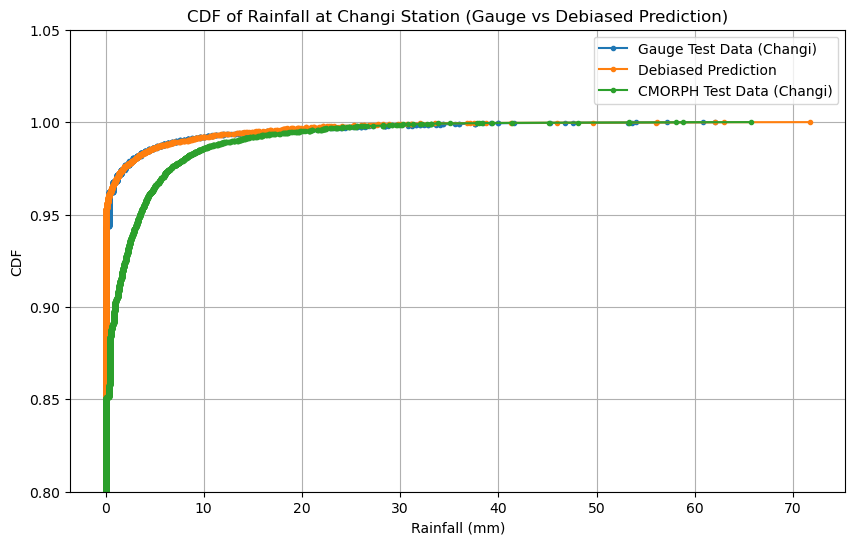


Threshold values for specified probabilities:
Probabilities:  [0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
Gauge Test Data Thresholds:  [0.0, 0.0, 0.0, 7.6, 36.0, 60.8]
Debiased Prediction Thresholds:  [0.0, 0.0, 0.0, 8.363842531196527, 30.696972214998407, 62.940781615106346]
Original CMORPH Thresholds:  [0.0, 0.0, 0.96, 13.46, 32.76, 58.739998]


In [2]:


# Load datasets
CMORPH = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\CMORPH_10yrs.csv")
Gauge = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\Data_gov_Station_10_years.csv")

# Convert the 'Date' column to datetime for CMORPH
CMORPH["Datetime"] = pd.to_datetime(CMORPH["Datetime"])

# Convert the 'Datetime' column to datetime for Gauge
Gauge["Datetime"] = pd.to_datetime(Gauge["Datetime"], format='%d/%m/%Y %H:%M')

# Define the date range
start_date = '2016-03-12'
end_date = '2021-12-31'

# Filter the data for the date range
CMORPH = CMORPH.loc[(CMORPH['Datetime'] > start_date) & (CMORPH['Datetime'] <= end_date)]
Gauge = Gauge.loc[(Gauge['Datetime'] > start_date) & (Gauge['Datetime'] <= end_date)]

# Resample Gauge data to 30-minute intervals by summing
Gauge = Gauge.set_index('Datetime').resample('30T').sum().reset_index()

# Split the data into training (2016 to 2020) and testing (2020 to 2021) sets
train_start_date = '2016-03-12'
train_end_date = '2020-12-31'
test_start_date = '2021-01-01'
test_end_date = '2021-12-31'

# Training data
CMORPH_train = CMORPH.loc[(CMORPH['Datetime'] >= train_start_date) & (CMORPH['Datetime'] <= train_end_date)]
Gauge_train = Gauge.loc[(Gauge['Datetime'] >= train_start_date) & (Gauge['Datetime'] <= train_end_date)]

# Testing data
CMORPH_test = CMORPH.loc[(CMORPH['Datetime'] >= test_start_date) & (CMORPH['Datetime'] <= test_end_date)]
Gauge_test = Gauge.loc[(Gauge['Datetime'] >= test_start_date) & (Gauge['Datetime'] <= test_end_date)]

# Extract "Changi" data
CMORPH_train_changi = CMORPH_train[['Datetime', 'Changi']].rename(columns={'Changi': 'CMORPH_Changi'})
Gauge_train_changi = Gauge_train[['Datetime', 'Changi']].rename(columns={'Changi': 'Gauge_Changi'})
CMORPH_test_changi = CMORPH_test[['Datetime', 'Changi']].rename(columns={'Changi': 'CMORPH_Changi'})
Gauge_test_changi = Gauge_test[['Datetime', 'Changi']].rename(columns={'Changi': 'Gauge_Changi'})

# Combine the dataframes by datetime for training and testing sets
train_combined = pd.merge(CMORPH_train_changi, Gauge_train_changi, on='Datetime', how='inner').dropna()
test_combined = pd.merge(CMORPH_test_changi, Gauge_test_changi, on='Datetime', how='inner').dropna()

# Prepare data for debiasing
CMORPH_train_changi_values = train_combined['CMORPH_Changi'].values * 2
Gauge_train_changi_values = train_combined['Gauge_Changi'].values * 2
CMORPH_test_changi_values = test_combined['CMORPH_Changi'].values * 2
Gauge_test_changi_values = test_combined['Gauge_Changi'].values * 2

# Ensure there are no missing values
assert not np.isnan(CMORPH_train_changi_values).any()
assert not np.isnan(Gauge_train_changi_values).any()
assert not np.isnan(CMORPH_test_changi_values).any()
assert not np.isnan(Gauge_test_changi_values).any()

# Reshape to 3D arrays (time, x, y) - we use x=y=1 since data is 1D time series
CMORPH_train_changi_3d = CMORPH_train_changi_values.reshape((-1, 1, 1))
Gauge_train_changi_3d = Gauge_train_changi_values.reshape((-1, 1, 1))
CMORPH_test_changi_3d = CMORPH_test_changi_values.reshape((-1, 1, 1))
Gauge_test_changi_3d = Gauge_test_changi_values.reshape((-1, 1, 1))

# Display the shapes to verify
print("CMORPH Training Data (Changi) 3D Shape:", CMORPH_train_changi_3d.shape)
print("Gauge Training Data (Changi) 3D Shape:", Gauge_train_changi_3d.shape)
print("CMORPH Testing Data (Changi) 3D Shape:", CMORPH_test_changi_3d.shape)
print("Gauge Testing Data (Changi) 3D Shape:", Gauge_test_changi_3d.shape)

# Debias using Quantile Mapping
debiaser = QuantileMapping.from_variable('pr')
prediction_3d = debiaser.apply(Gauge_train_changi_3d, CMORPH_train_changi_3d, CMORPH_test_changi_3d)

# Flatten the 3D prediction array to 1D for evaluation
prediction = prediction_3d.flatten()

# Calculate MAE
mae_value = mean_absolute_error(Gauge_test_changi_values, prediction)

# Print the MAE value
print(f'MAE between debiased prediction and Gauge test data: {mae_value}')
print(f"MAE between CMORPH test data and Gauge test data: {mean_absolute_error(CMORPH_test_changi_values, Gauge_test_changi_values)}")
# Calculate CDF
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Calculate CDF for Gauge test data and predicted data
Gauge_test_sorted, Gauge_test_cdf = calculate_cdf(Gauge_test_changi_values)
prediction_sorted, prediction_cdf = calculate_cdf(prediction)
CMORPH_test_changi_sorted, CMORPH_test_changi_cdf = calculate_cdf(CMORPH_test_changi_values)

# Plot CDF
plt.figure(figsize=(10, 6))
plt.plot(Gauge_test_sorted, Gauge_test_cdf, label='Gauge Test Data (Changi)', linestyle='-', marker='.')
plt.plot(prediction_sorted, prediction_cdf, label='Debiased Prediction', linestyle='-', marker='.')
plt.plot(CMORPH_test_changi_sorted, CMORPH_test_changi_cdf, label='CMORPH Test Data (Changi)', linestyle='-', marker='.')
plt.xlabel('Rainfall (mm)')
plt.ylim([0.8, 1.05])
plt.ylabel('CDF')
plt.title('CDF of Rainfall at Changi Station (Gauge vs Debiased Prediction)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate threshold values for specific probabilities
def calculate_thresholds(data, probabilities):
    thresholds = []
    sorted_data = np.sort(data)
    for p in probabilities:
        thresholds.append(sorted_data[int(p * len(sorted_data))])
    return thresholds

# Specify probabilities
probabilities = [0.5,0.75, 0.9, 0.99,0.999,0.9999]

# Calculate thresholds for Gauge test data and predicted data
Gauge_test_thresholds = calculate_thresholds(Gauge_test_changi_values, probabilities)
prediction_thresholds = calculate_thresholds(prediction, probabilities)
original = calculate_thresholds(CMORPH_test_changi_values, probabilities)
# Print the threshold values
print("\nThreshold values for specified probabilities:")
print("Probabilities: ", probabilities)
print("Gauge Test Data Thresholds: ", Gauge_test_thresholds)
print("Debiased Prediction Thresholds: ", prediction_thresholds)
print("Original CMORPH Thresholds: ", original)


## Verifying effectiveness of Quantile Mapping on season scale

The software used by ITU 837 requires a recommended minimum of 10 years of data record for the model to have more accuracy in calculating R0.01%. As the data for rate of rainfall in Singapore is only available from 2016 onwards, the lack of "long-term" data might induce more uncertainty than intended. This code block aims to split the ground data and IMERG data into 80-20 for training and evaluating to determine if bias correction on a seasonal scale would lead to better fitting of IMERG data to ground truth.

Training: 2016 - 2021

Test: 2021 - 2022

Metric: Mean Absolute Error

100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


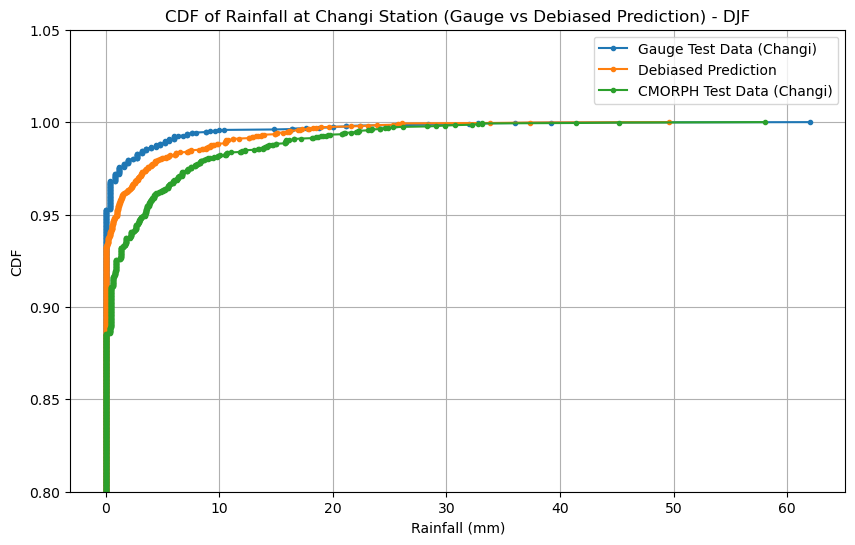

K-S test statistic for DJF: 0.027387640449438203, p-value: 0.08116275381790307

Threshold values for specified probabilities - DJF:
Probabilities:  [0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
Gauge Test Data Thresholds:  [0.0, 0.0, 0.0, 5.6, 32.0, 61.99998]
Debiased Prediction Thresholds:  [0.0, 0.0, 0.0, 10.599044540441202, 26.06677253035617, 49.54595339636141]
Original CMORPH Thresholds:  [0.0, 0.0, 0.45999998, 15.9, 33.1, 58.059998]
MAE between debiased prediction and Gauge test data for DJF: 0.43604122324387024
MAE between CMORPH test data and Gauge test data for DJF: 0.6564138438108614


100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


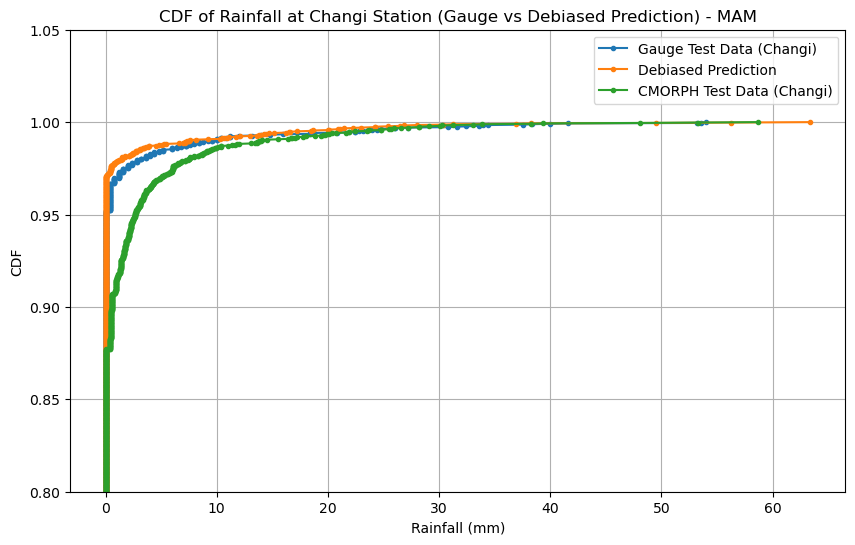

K-S test statistic for MAM: 0.020833333333333332, p-value: 0.2932809689771751

Threshold values for specified probabilities - MAM:
Probabilities:  [0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
Gauge Test Data Thresholds:  [0.0, 0.0, 0.0, 9.600000000000001, 40.0, 54.0]
Debiased Prediction Thresholds:  [0.0, 0.0, 0.0, 7.52109822877688, 36.92403492505166, 63.37741307346072]
Original CMORPH Thresholds:  [0.0, 0.0, 0.53999996, 13.96, 38.32, 58.739998]
MAE between debiased prediction and Gauge test data for MAM: 0.5772896196091247
MAE between CMORPH test data and Gauge test data for MAM: 0.8807200946512681


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


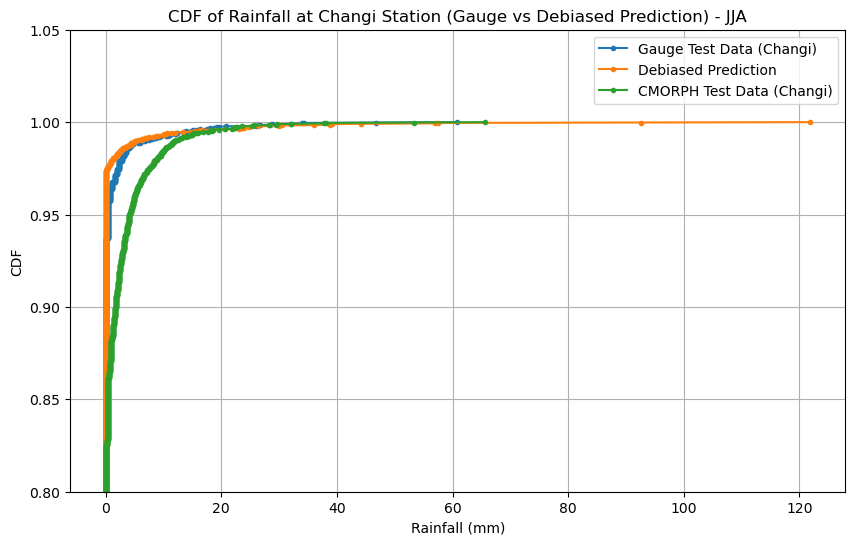

K-S test statistic for JJA: 0.0384963768115942, p-value: 0.002873820955037269

Threshold values for specified probabilities - JJA:
Probabilities:  [0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
Gauge Test Data Thresholds:  [0.0, 0.0, 0.0, 6.8, 32.0, 60.8]
Debiased Prediction Thresholds:  [0.0, 0.0, 0.0, 5.347892520234725, 44.21529146330327, 121.82455050905993]
Original CMORPH Thresholds:  [0.0, 0.0, 1.74, 12.0199996, 32.02, 65.68]
MAE between debiased prediction and Gauge test data for JJA: 0.520263572659099
MAE between CMORPH test data and Gauge test data for JJA: 0.9074229951630435


100%|██████████| 1/1 [00:00<00:00, 503.22it/s]


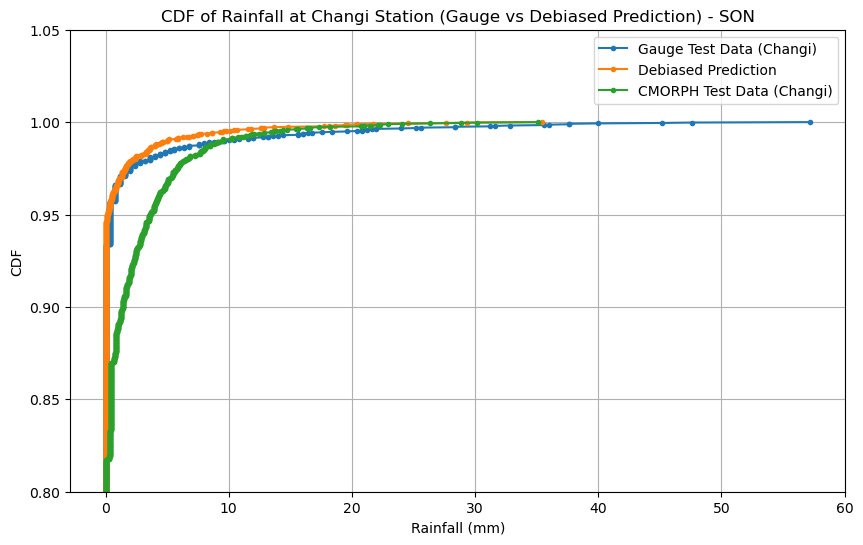

K-S test statistic for SON: 0.02358058608058608, p-value: 0.17617393195822342

Threshold values for specified probabilities - SON:
Probabilities:  [0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
Gauge Test Data Thresholds:  [0.0, 0.0, 0.0, 10.0, 37.6, 57.2]
Debiased Prediction Thresholds:  [0.0, 0.0, 0.0, 5.05415689658317, 21.75720569959097, 35.46440128969891]
Original CMORPH Thresholds:  [0.0, 0.0, 1.43999994, 9.5, 24.039999, 35.1]
MAE between debiased prediction and Gauge test data for SON: 0.5051613868645343
MAE between CMORPH test data and Gauge test data for SON: 0.8327426613232601

All Results:
{'Season': 'DJF', 'MAE': 0.43604122324387024, 'KS Statistic': 0.027387640449438203, 'KS P-Value': 0.08116275381790307, 'Gauge Thresholds': [0.0, 0.0, 0.0, 5.6, 32.0, 61.99998], 'Prediction Thresholds': [0.0, 0.0, 0.0, 10.599044540441202, 26.06677253035617, 49.54595339636141], 'Original Thresholds': [0.0, 0.0, 0.45999998, 15.9, 33.1, 58.059998]}
{'Season': 'MAM', 'MAE': 0.5772896196091247, 'KS Statis

In [3]:
warnings.filterwarnings("ignore")

# Load datasets
CMORPH = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\CMORPH_10yrs.csv")
Gauge = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\Data_gov_Station_10_years.csv")

# Convert the 'Date' column to datetime for CMORPH
CMORPH["Datetime"] = pd.to_datetime(CMORPH["Datetime"])

# Convert the 'Datetime' column to datetime for Gauge
Gauge["Datetime"] = pd.to_datetime(Gauge["Datetime"], format='%d/%m/%Y %H:%M')

# Define the date range
start_date = '2016-03-12'
end_date = '2021-12-31'

# Filter the data for the date range
CMORPH = CMORPH.loc[(CMORPH['Datetime'] > start_date) & (CMORPH['Datetime'] <= end_date)]
Gauge = Gauge.loc[(Gauge['Datetime'] > start_date) & (Gauge['Datetime'] <= end_date)]

# Resample Gauge data to 30-minute intervals by summing
Gauge = Gauge.set_index('Datetime').resample('30T').sum().reset_index()

# Define seasons
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'DJF'  # Winter
    elif month in [3, 4, 5]:
        return 'MAM'  # Spring
    elif month in [6, 7, 8]:
        return 'JJA'  # Summer
    elif month in [9, 10, 11]:
        return 'SON'  # Autumn

CMORPH['Season'] = CMORPH['Datetime'].apply(get_season)
Gauge['Season'] = Gauge['Datetime'].apply(get_season)

# Split the data into training (2016 to 2020) and testing (2020 to 2021) sets by seasons
train_start_date = '2016-03-12'
train_end_date = '2020-12-31'
test_start_date = '2021-01-01'
test_end_date = '2021-12-31'

# Function to calculate CDF
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Function to calculate thresholds for specific probabilities
def calculate_thresholds(data, probabilities):
    sorted_data = np.sort(data)
    thresholds = [sorted_data[int(p * len(sorted_data))] for p in probabilities]
    return thresholds

results = []

for season in ['DJF', 'MAM', 'JJA', 'SON']:
    # Training data
    CMORPH_train = CMORPH.loc[(CMORPH['Datetime'] >= train_start_date) & (CMORPH['Datetime'] <= train_end_date) & (CMORPH['Season'] == season)]
    Gauge_train = Gauge.loc[(Gauge['Datetime'] >= train_start_date) & (Gauge['Datetime'] <= train_end_date) & (Gauge['Season'] == season)]

    # Testing data
    CMORPH_test = CMORPH.loc[(CMORPH['Datetime'] >= test_start_date) & (CMORPH['Datetime'] <= test_end_date) & (CMORPH['Season'] == season)]
    Gauge_test = Gauge.loc[(Gauge['Datetime'] >= test_start_date) & (Gauge['Datetime'] <= test_end_date) & (Gauge['Season'] == season)]

    # Extract "Changi" data
    CMORPH_train_changi = CMORPH_train[['Datetime', 'Changi']].rename(columns={'Changi': 'CMORPH_Changi'})
    Gauge_train_changi = Gauge_train[['Datetime', 'Changi']].rename(columns={'Changi': 'Gauge_Changi'})
    CMORPH_test_changi = CMORPH_test[['Datetime', 'Changi']].rename(columns={'Changi': 'CMORPH_Changi'})
    Gauge_test_changi = Gauge_test[['Datetime', 'Changi']].rename(columns={'Changi': 'Gauge_Changi'})

    # Combine the dataframes by datetime for training and testing sets
    train_combined = pd.merge(CMORPH_train_changi, Gauge_train_changi, on='Datetime', how='inner').dropna()
    test_combined = pd.merge(CMORPH_test_changi, Gauge_test_changi, on='Datetime', how='inner').dropna()

    # Prepare data for debiasing
    CMORPH_train_changi_values = train_combined['CMORPH_Changi'].values * 2
    Gauge_train_changi_values = train_combined['Gauge_Changi'].values * 2
    CMORPH_test_changi_values = test_combined['CMORPH_Changi'].values * 2
    Gauge_test_changi_values = test_combined['Gauge_Changi'].values * 2

    # Ensure there are no missing values
    assert not np.isnan(CMORPH_train_changi_values).any()
    assert not np.isnan(Gauge_train_changi_values).any()
    assert not np.isnan(CMORPH_test_changi_values).any()
    assert not np.isnan(Gauge_test_changi_values).any()

    # Reshape to 3D arrays (time, x, y) - we use x=y=1 since data is 1D time series
    CMORPH_train_changi_3d = CMORPH_train_changi_values.reshape((-1, 1, 1))
    Gauge_train_changi_3d = Gauge_train_changi_values.reshape((-1, 1, 1))
    CMORPH_test_changi_3d = CMORPH_test_changi_values.reshape((-1, 1, 1))
    Gauge_test_changi_3d = Gauge_test_changi_values.reshape((-1, 1, 1))

    # Debias using Quantile Mapping
    debiaser = QuantileMapping.from_variable("pr")
    prediction_3d = debiaser.apply(Gauge_train_changi_3d, CMORPH_train_changi_3d, CMORPH_test_changi_3d)

    # Flatten the 3D prediction array to 1D for evaluation
    prediction = prediction_3d.flatten()

    # Calculate MAE
    mae_value = mean_absolute_error(Gauge_test_changi_values, prediction)

    # Calculate CDF for Gauge test data and predicted data
    Gauge_test_sorted, Gauge_test_cdf = calculate_cdf(Gauge_test_changi_values)
    prediction_sorted, prediction_cdf = calculate_cdf(prediction)
    CMORPH_test_changi_sorted, CMORPH_test_changi_cdf = calculate_cdf(CMORPH_test_changi_values)

    # Plot CDF
    plt.figure(figsize=(10, 6))
    plt.plot(Gauge_test_sorted, Gauge_test_cdf, label='Gauge Test Data (Changi)', linestyle='-', marker='.')
    plt.plot(prediction_sorted, prediction_cdf, label='Debiased Prediction', linestyle='-', marker='.')
    plt.plot(CMORPH_test_changi_sorted, CMORPH_test_changi_cdf, label='CMORPH Test Data (Changi)', linestyle='-', marker='.')
    plt.xlabel('Rainfall (mm)')
    plt.ylim([0.8, 1.05])
    plt.ylabel('CDF')
    plt.title(f'CDF of Rainfall at Changi Station (Gauge vs Debiased Prediction) - {season}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate K-S test
    ks_statistic, ks_p_value = kstest(prediction, Gauge_test_changi_values)
    print(f"K-S test statistic for {season}: {ks_statistic}, p-value: {ks_p_value}")

    # Calculate threshold values for specific probabilities
    probabilities = [0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
    Gauge_test_thresholds = calculate_thresholds(Gauge_test_changi_values, probabilities)
    prediction_thresholds = calculate_thresholds(prediction, probabilities)
    original_thresholds = calculate_thresholds(CMORPH_test_changi_values, probabilities)

    # Print the results
    print(f"\nThreshold values for specified probabilities - {season}:")
    print("Probabilities: ", probabilities)
    print("Gauge Test Data Thresholds: ", Gauge_test_thresholds)
    print("Debiased Prediction Thresholds: ", prediction_thresholds)
    print("Original CMORPH Thresholds: ", original_thresholds)
    print(f"MAE between debiased prediction and Gauge test data for {season}: {mae_value}")
    print(f"MAE between CMORPH test data and Gauge test data for {season}: {mean_absolute_error(CMORPH_test_changi_values, Gauge_test_changi_values)}")

    results.append({
        'Season': season,
        'MAE': mae_value,
        'KS Statistic': ks_statistic,
        'KS P-Value': ks_p_value,
        'Gauge Thresholds': Gauge_test_thresholds,
        'Prediction Thresholds': prediction_thresholds,
        'Original Thresholds': original_thresholds
    })

# Display all results
print("\nAll Results:")
for result in results:
    print(result)


# Conclusion
From the above graphs and metrics, we can conclude that bias correction does increase the accuracy of the data set as the MAE is lower. The KS test also shows that the bias corrected data is more "in line" with rain gauge data evident by the decrease in KS stat (lower means better) and with p-value > 0.05 indicating the distributions are no significantly different.

## Quantile mapping seasonal (10 years)

8 years of ground data used to bias correct 8 years of IMERG data via Quantile Mapping method which was then applied to 10 years of IMERG data from 2014 to 2023 to obtain CDF. CDF will then be plugged into ITU837 to obtain R0.01% value.

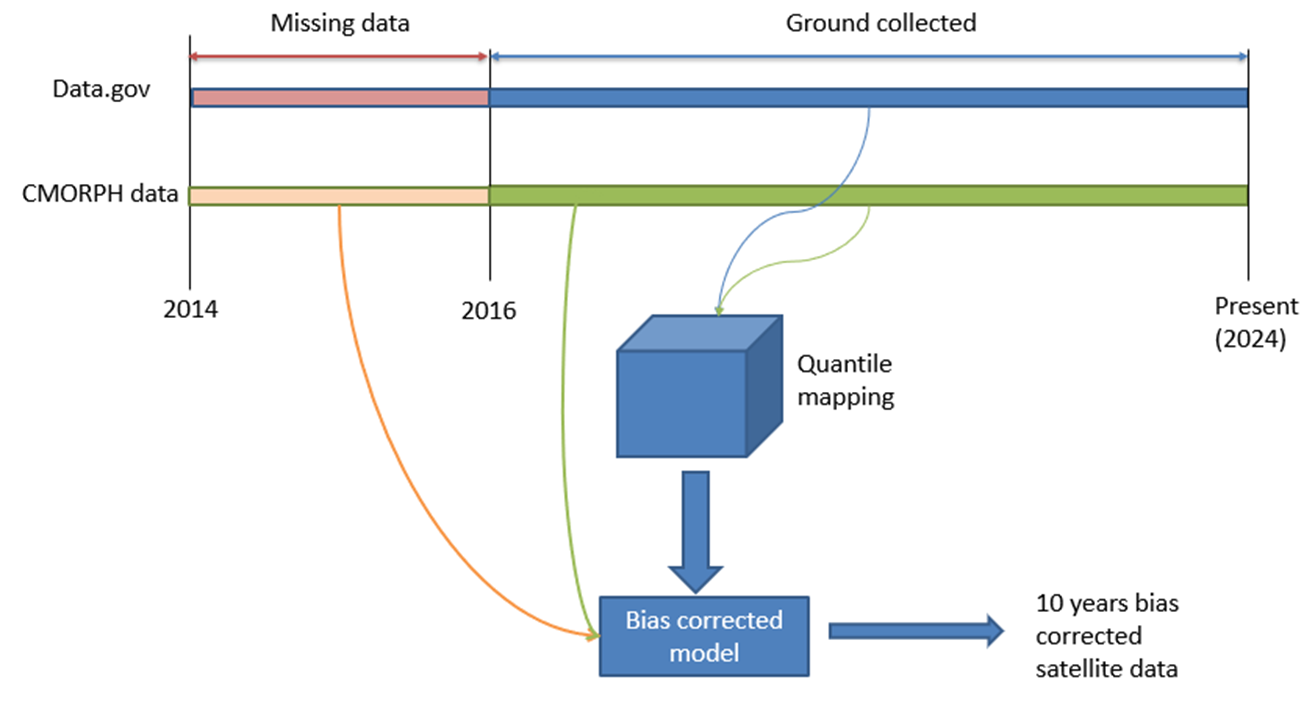

100%|██████████| 1/1 [00:00<00:00, 125.01it/s]


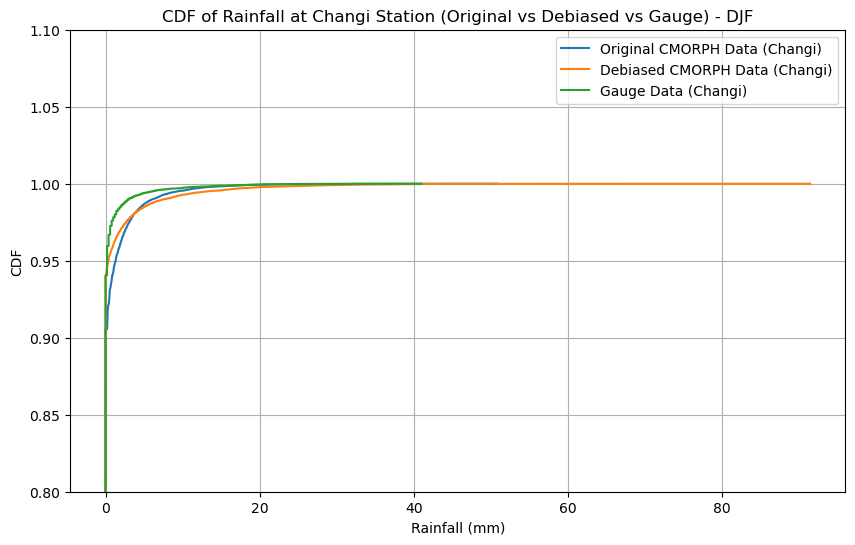


Threshold values for specified probabilities - DJF:
Probabilities:  ['50.0%', '25.0%', '10.0%', '5.0%', '1.0%', '0.1%', '0.01%']
Original CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 1.31, 6.12, 17.67, 27.67]
Debiased CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 0.3747191177089548, 7.599720748658179, 28.44519326502628, 47.18735183235103]
Gauge Data Thresholds:  [0.0, 0.0, 0.0, 0.2, 3.0, 17.6, 32.60001]


100%|██████████| 1/1 [00:00<?, ?it/s]


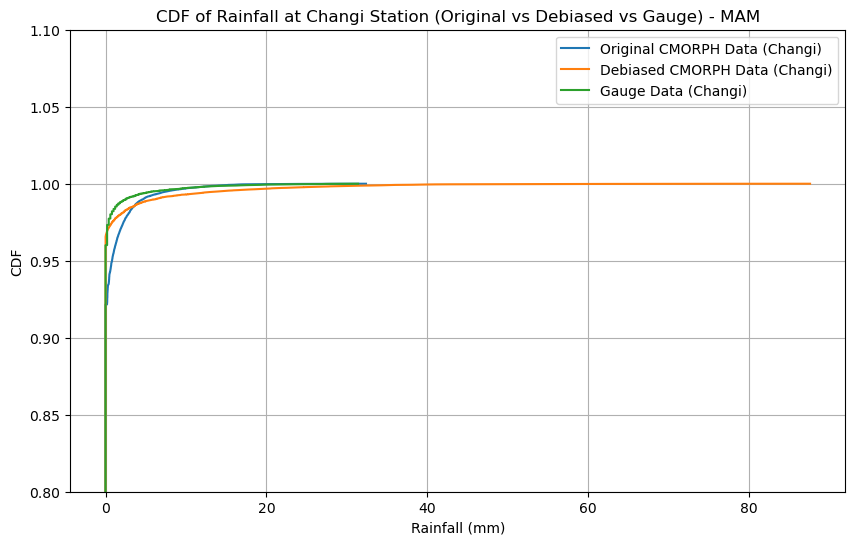


Threshold values for specified probabilities - MAM:
Probabilities:  ['50.0%', '25.0%', '10.0%', '5.0%', '1.0%', '0.1%', '0.01%']
Original CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 0.81, 4.71, 14.91, 25.15]
Debiased CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 0.0, 6.279073464793165, 35.040269014989846, 65.66569745486134]
Gauge Data Thresholds:  [0.0, 0.0, 0.0, 0.0, 2.6, 17.0, 28.0]


100%|██████████| 1/1 [00:00<00:00, 124.96it/s]


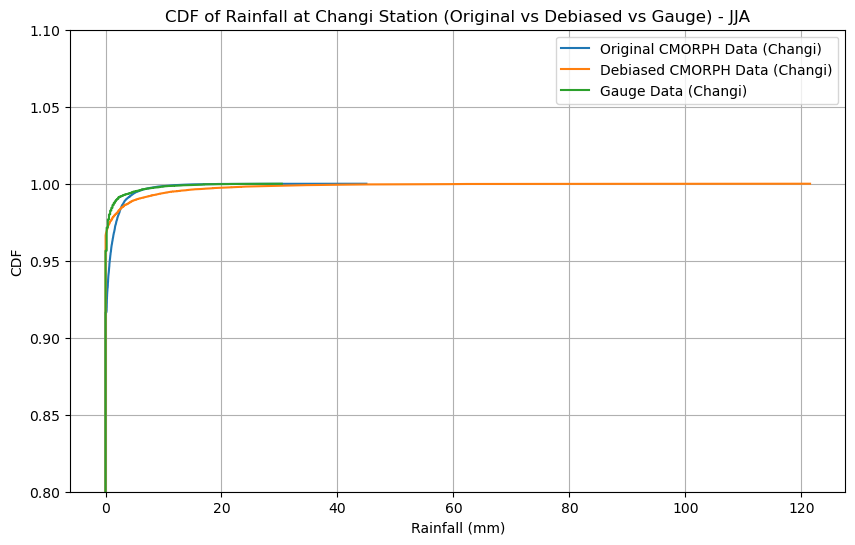


Threshold values for specified probabilities - JJA:
Probabilities:  ['50.0%', '25.0%', '10.0%', '5.0%', '1.0%', '0.1%', '0.01%']
Original CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 0.72999996, 3.6, 11.62, 26.289999]
Debiased CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 0.0, 5.497907196505074, 33.379192176516995, 88.15925499204006]
Gauge Data Thresholds:  [0.0, 0.0, 0.0, 0.0, 2.0, 13.4, 23.400000000000002]


100%|██████████| 1/1 [00:00<00:00, 112.94it/s]


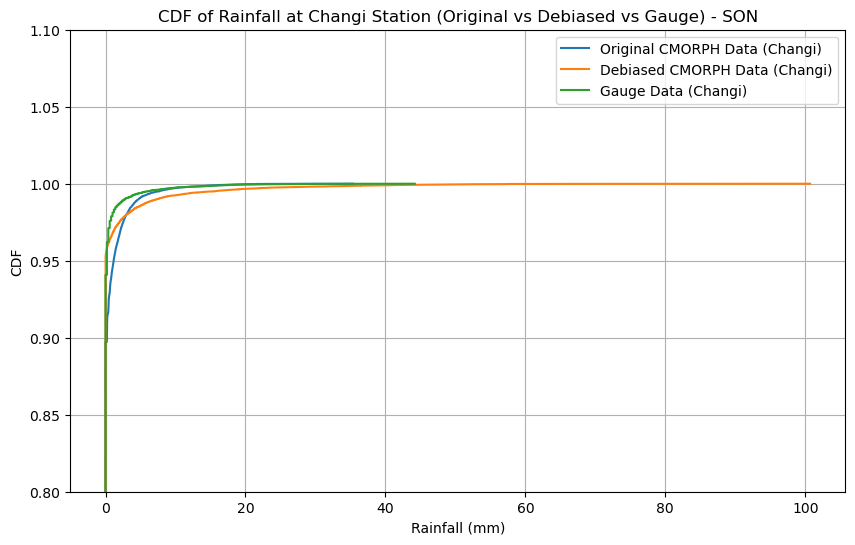


Threshold values for specified probabilities - SON:
Probabilities:  ['50.0%', '25.0%', '10.0%', '5.0%', '1.0%', '0.1%', '0.01%']
Original CMORPH Data Thresholds:  [0.0, 0.0, 0.19999999, 1.16, 4.74, 15.95, 24.939999]
Debiased CMORPH Data Thresholds:  [0.0, 0.0, 0.0, 0.0, 7.42013640245438, 40.354672503265625, 68.11733940613664]
Gauge Data Thresholds:  [0.0, 0.0, 0.0, 0.2, 2.8, 17.200000000000003, 32.0]

All Results:
{'Season': 'DJF', 'Original Thresholds': [0.0, 0.0, 0.0, 1.31, 6.12, 17.67, 27.67], 'Debiased Thresholds': [0.0, 0.0, 0.0, 0.3747191177089548, 7.599720748658179, 28.44519326502628, 47.18735183235103], 'Gauge Thresholds': [0.0, 0.0, 0.0, 0.2, 3.0, 17.6, 32.60001]}
{'Season': 'MAM', 'Original Thresholds': [0.0, 0.0, 0.0, 0.81, 4.71, 14.91, 25.15], 'Debiased Thresholds': [0.0, 0.0, 0.0, 0.0, 6.279073464793165, 35.040269014989846, 65.66569745486134], 'Gauge Thresholds': [0.0, 0.0, 0.0, 0.0, 2.6, 17.0, 28.0]}
{'Season': 'JJA', 'Original Thresholds': [0.0, 0.0, 0.0, 0.72999996, 3.

In [8]:

warnings.filterwarnings("ignore")

# Load datasets
CMORPH = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\CMORPH_10yrs.csv")
Gauge = pd.read_csv(r"C:\Users\userAdmin\Desktop\Data comparison\Datasets\Data_gov_Station_10_years.csv")


# Convert the 'Date' column to datetime for CMORPH
CMORPH["Datetime"] = pd.to_datetime(CMORPH["Datetime"])

# Convert the 'Datetime' column to datetime for Gauge
Gauge["Datetime"] = pd.to_datetime(Gauge["Datetime"], format='%d/%m/%Y %H:%M')

# Define the date range
start_date = '2016-03-12'
end_date = '2021-12-31'

# Filter the data for the date range
Gauge = Gauge.loc[(Gauge['Datetime'] > start_date) & (Gauge['Datetime'] <= end_date)]
Gauge = Gauge.set_index('Datetime').resample('30T').sum().reset_index()

# Define seasons
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'DJF'  # Winter
    elif month in [3, 4, 5]:
        return 'MAM'  # Spring
    elif month in [6, 7, 8]:
        return 'JJA'  # Summer
    elif month in [9, 10, 11]:
        return 'SON'  # Autumn

CMORPH['Season'] = CMORPH['Datetime'].apply(get_season)
Gauge['Season'] = Gauge['Datetime'].apply(get_season)

# Prepare results storage
results = []

# Split data by season and train debiaser for each season
for season in ['DJF', 'MAM', 'JJA', 'SON']:
    # Training data for the current season
    CMORPH_train = CMORPH.loc[(CMORPH['Datetime'] >= start_date) & (CMORPH['Datetime'] <= end_date) & (CMORPH['Season'] == season)]
    Gauge_train = Gauge.loc[Gauge['Season'] == season]
    
    # Extract "Changi" data
    CMORPH_train_Changi = CMORPH_train[['Datetime', 'Changi']].rename(columns={'Changi': 'CMORPH_Changi'})
    Gauge_train_Changi = Gauge_train[['Datetime', 'Changi']].rename(columns={'Changi': 'Gauge_Changi'})
   
    Gauge_train_Changi['Gauge_Changi'] *= 2
    # Combine the dataframes by datetime for training sets
    train_combined = pd.merge(CMORPH_train_Changi, Gauge_train_Changi, on='Datetime', how='inner').dropna()
    
    # Prepare data for debiasing
    CMORPH_train_Changi_values = train_combined['CMORPH_Changi'].values
    Gauge_train_Changi_values = train_combined['Gauge_Changi'].values
    # Ensure there are no missing values
    assert not np.isnan(CMORPH_train_Changi_values).any()
    assert not np.isnan(Gauge_train_Changi_values).any()
    
    # Reshape to 3D arrays (time, x, y) - we use x=y=1 since data is 1D time series
    CMORPH_train_Changi_3d = CMORPH_train_Changi_values.reshape((-1, 1, 1))
    Gauge_train_Changi_3d = Gauge_train_Changi_values.reshape((-1, 1, 1))
    # Apply debiaser to the entire CMORPH data for the current season
    CMORPH_season = CMORPH[CMORPH['Season'] == season]
    CMORPH_season_Changi_values = CMORPH_season['Changi'].values
    CMORPH_season_Changi_3d = CMORPH_season_Changi_values.reshape((-1, 1, 1))

    
    # Train debiaser for the current season <---------------------------------------- debiaser
    debiaser = QuantileMapping.from_variable("pr")
    debiased_season_3d = debiaser.apply(Gauge_train_Changi_3d, CMORPH_train_Changi_3d, CMORPH_season_Changi_3d)
    
    
    debiased_season_flat = debiased_season_3d.flatten()
    # Store debiased results
    CMORPH.loc[CMORPH['Season'] == season, 'Debiased'] = debiased_season_flat
    
    # Function to calculate CDF
    def calculate_cdf(data):
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        return sorted_data, cdf
    
    # Function to calculate thresholds for specified probabilities
    def calculate_thresholds(data, probabilities):
        thresholds = []
        sorted_data = np.sort(data)
        for p in probabilities:
            thresholds.append(sorted_data[int(p * len(sorted_data))])
        return thresholds
    
    # Probabilities for threshold calculation
    probabilities = [0.5, 0.75, 0.9,0.95, 0.99, 0.999, 0.9999]
    
    # Calculate CDF for original and debiased data
    original_data = CMORPH_season_Changi_values
    debiased_data = debiased_season_flat
    original_sorted, original_cdf = calculate_cdf(original_data)
    debiased_sorted, debiased_cdf = calculate_cdf(debiased_data)
    
    # Plot CDF
    plt.figure(figsize=(10, 6))
    plt.plot(original_sorted, original_cdf, label='Original CMORPH Data (Changi)', linestyle='-')
    plt.plot(debiased_sorted, debiased_cdf, label='Debiased CMORPH Data (Changi)', linestyle='-')
    plt.ylim(0.8,1.1)
    
    # Calculate and plot CDF for Gauge data
    Gauge_season = Gauge[Gauge['Season'] == season]
    Gauge_season_Changi_values = Gauge_season['Changi'].values
    gauge_sorted, gauge_cdf = calculate_cdf(Gauge_season_Changi_values)
    plt.plot(gauge_sorted, gauge_cdf, label='Gauge Data (Changi)', linestyle='-')
    
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('CDF')
    plt.title(f'CDF of Rainfall at Changi Station (Original vs Debiased vs Gauge) - {season}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate thresholds
    original_thresholds = calculate_thresholds(original_data, probabilities)
    debiased_thresholds = calculate_thresholds(debiased_data, probabilities)
    gauge_thresholds = calculate_thresholds(Gauge_season_Changi_values, probabilities)
    
    # Print the results
    print(f"\nThreshold values for specified probabilities - {season}:")
    print("Probabilities: ", [f"{round((1-probabilities[i])*100,3)}%" for i in range(len(probabilities))])
    print("Original CMORPH Data Thresholds: ", original_thresholds)
    print("Debiased CMORPH Data Thresholds: ", debiased_thresholds)
    print("Gauge Data Thresholds: ", gauge_thresholds)
    
    results.append({
        'Season': season,
        'Original Thresholds': original_thresholds,
        'Debiased Thresholds': debiased_thresholds,
        'Gauge Thresholds': gauge_thresholds
    })

# Display all results
print("\nAll Results:")
for result in results:
    print(result)


Visualising the difference of R0.01% from MatLab (barchart) against python (baseline)

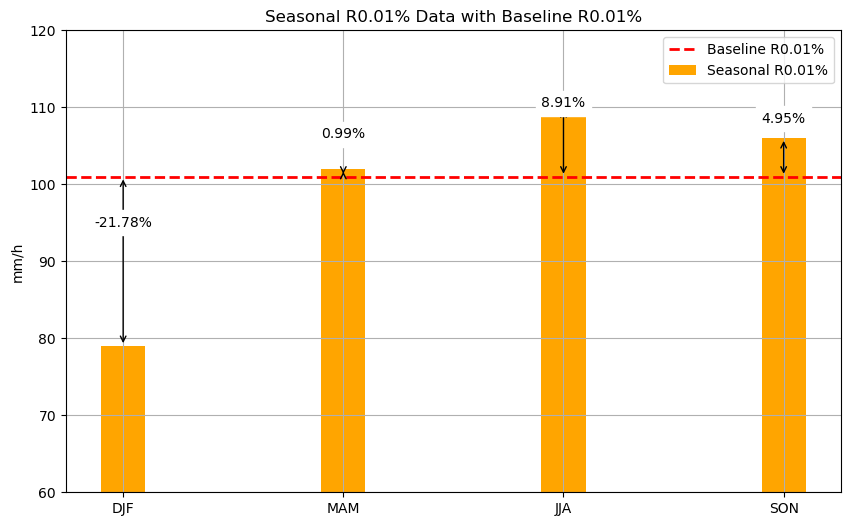

In [ ]:
# Plotting the data with an updated and more visible baseline

plt.figure(figsize=(10, 6))

# Plot seasonal data for 2023
seasons = ['DJF', 'MAM', 'JJA', 'SON']
values = [79,102,110,106] # <------------- Input after Matlab
plt.bar(seasons, values, label='Seasonal R0.01%', color='orange', width=0.2)

# Plot annual data for 2015 as a baseline with more visible properties
plt.axhline(y=101, color='red', linestyle='--', linewidth=2, label='Baseline R0.01%')
# Adding arrows to highlight the difference between the baseline and seasonal values
for i, season in enumerate(seasons):
    plt.annotate('', xy=(i, values[i]), xytext=(i, 101),
                 arrowprops=dict(arrowstyle='<->', color='black'))

    # Adding text to show the difference in mm/h
    plt.text(i, (values[i] + 101) / 2+5, f'{round((values[i] - 101)/101*100,2)}%', 
             ha='center', va='center', backgroundcolor='white')

# Adding titles and labels
plt.title('Seasonal R0.01% Data with Baseline R0.01%')
plt.ylabel('mm/h')
plt.ylim(60, 120)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
